# Named Entity Recognition

### Dự đoán named entities trong cơ sở dữ liệu GMB(Groningen Meaning Bank)

Sử dụng Sequence Tagging với mô hình LSTM-CRF để trích xuất tên các thực thể trong văn bản
nhãn các thực thể được mã hóa sử dụng các ký hiệu BIO, trong đó mỗi nhãn thực thể được gán với ký hiệu B hoặc I. B- ký hiệu là bắt đầu (begining) và I- là bên trong (inside) một thực thể. Các ký hiệu này dùng để xác định các thực thể có nhiều từ, ví dụ với câu :"World War II", các nhãn là:(B-eve, I-eve, I-eve). Các từ khác, không thuộc thực thể được gán nhãn là O.
Tag | Label meaning | Example Given
------------ | ------------- |
geo | Geographical Entity | London
org | Organization | ONU
per | Person | Bush
gpe | Geopolitical Entity | British
tim | Time indicator | Wednesday
art | Artifact | Chrysler
eve | Event | Christmas
nat | Natural Phenomenon | Hurricane
O | No-Label | the

Chúng ta sẽ thực hiện:
- Preprocess text data for NLP
- Build and train a Bi-directional LSTM-CRF model using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own sentences!
Mô hình:
<img src="https://raw.githubusercontent.com/floydhub/named-entity-recognition-template/master/images/bilstm-crf.png" width="400" height="400" align="center"/>

In [1]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/NLP_Vinbig/NLP_09

/content/drive/MyDrive/NLP_Vinbig/NLP_09


## Các tham số

In [ ]:
# Hyperparams if GPU is available
if tf.config.list_physical_devices('GPU'):
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector


# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

## Data

In [ ]:
# đọc dữ liệu csv với pandas
data = pd.read_csv('ner_dataset.csv', encoding='unicode_escape')
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-geo', 'B-nat', 'I-eve', 'B-eve', 'I-per', 'I-tim', 'B-tim', 'B-org', 'I-nat', 'I-art', 'B-gpe', 'I-org', 'I-gpe', 'B-art', 'O', 'B-per', 'B-geo']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


As you can see from the output Cell above, each sentence in the dataset is represented as a list of tuple: [`(Token_1, PoS_1, Tag_1)`, ..., `(Token_n, PoS_n, Tag_n)`].

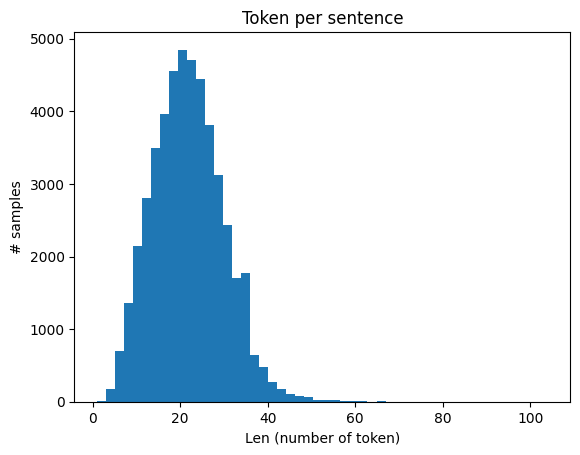

In [ ]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Tiền xử lý dữ liệu

-Sử dụng từ điển `word2idx` để chuyển 1 từ thành 1 số nguyên ID và tương tự từ điển `tag2idx` cho nhãn
- Padding tất cả các câu có cùng số từ `MAX_LEN`

In [ ]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Biểu diễn vector cho các câu, mỗi từ --> 1 số nguyên, câu => vector
X = [[word2idx[word] for word, _, _ in sent] for sent in sentences]
# Padding các câu về cùng chiều dài MAXLEN
X = pad_sequences(X, value=word2idx['PAD'], padding='post', truncating='post', maxlen=MAX_LEN)

# tương tự với các nhãn (Tag/Label)
# Convert Tag/Label to tag_index
y = [[tag2idx[tag] for _, _, tag in sent] for sent in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(y, value=tag2idx['PAD'], padding='post', truncating='post', maxlen=MAX_LEN)

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
print(X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape)

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 29096
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 17
(43163, 75) (4796, 75) (43163, 75, 18) (4796, 75, 18)
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [11421 30871  8488 25335 15558 31510 23911 25694 27439 21708 18874  3975
 32267  2171 33541 21708  7419 30871 31992 16010 32653   689  5492 18357
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0.

In [ ]:
!pip install -q tf2crf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 15.1 MB/s eta 0:00:00


In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tf2crf import CRF, ModelWithCRFLoss

# Định nghĩa mô hình
# đầu vào
input = Input(shape=(MAX_LEN))
# lớp embedding
model = Embedding(n_words + 2, EMBEDDING, input_length=MAX_LEN, mask_zero=True)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model = ModelWithCRFLoss(model, sparse_target=False)
model.compile(optimizer="adam")
model.build(input_shape=(None, MAX_LEN))

model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model_with_crf_loss"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          ((None, 75),              1449892   
                              (None, 75, 18),                    
                              (None,),                           
                              (18, 18))                          
                                                                 
Total params: 1449896 (5.53 MB)
Trainable params: 1449892 (5.53 MB)
Non-trainable params: 4 (16.00 Byte)
_________________________________________________________________


## Huấn luyện và đánh giá mô hình

In [ ]:
# huấn luyện mô hình
history = model.fit(x=X_tr, y=np.array(y_tr), batch_size=BATCH_SIZE, epochs=5)

Epoch 1/5
85/85 [==============================] - 121s 1s/step - loss: 28.3087 - accuracy: 0.7177
Epoch 2/5
85/85 [==============================] - 118s 1s/step - loss: 13.2398 - accuracy: 0.8478
Epoch 3/5
85/85 [==============================] - 93s 1s/step - loss: 7.9423 - accuracy: 0.8863
Epoch 4/5
85/85 [==============================] - 80s 945ms/step - loss: 6.0428 - accuracy: 0.9185
Epoch 5/5
85/85 [==============================] - 79s 934ms/step - loss: 4.3838 - accuracy: 0.9478


In [ ]:
# Đánh giá mô hình trên tập test
pred_cat = tags
pred = model.predict(X_te, batch_size=BATCH_SIZE)
y_te_true = np.array(y_te).argmax(-1)

10/10 [==============================] - 2s 95ms/step


In [ ]:
!pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git

  Cloning https://github.com/MeMartijn/updated-sklearn-crfsuite.git to /tmp/pip-req-build-fogieoek
  Running command git clone --filter=blob:none --quiet https://github.com/MeMartijn/updated-sklearn-crfsuite.git /tmp/pip-req-build-fogieoek
  Resolved https://github.com/MeMartijn/updated-sklearn-crfsuite.git to commit 675038761b4405f04691a83339d04903790e2b95
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 16.8 MB/s eta 0:00:00
  Created wheel for sklearn-crfsuite: filename=sklearn_crfsuite-0.3.6-py2.py3-none-any.whl size=10868 sha256=bf89d1ab06f51869932285940c59c17596b7121325c76ef0f0c77a353adc051c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6kzb0de7/wheels/0b/bc/07/bd75a6f5fa2bf2ea05a5aad8d9ac66d2b5aab93dfd4e1a89de
Successfully built sklearn-crfsuite


In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true]

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        38
       B-eve       0.00      0.00      0.00        36
       B-geo       0.73      0.86      0.79      3714
       B-gpe       0.92      0.91      0.92      1643
       B-nat       0.00      0.00      0.00        18
       B-org       0.69      0.53      0.60      2015
       B-per       0.81      0.66      0.73      1691
       B-tim       0.87      0.74      0.80      2007
       I-art       0.00      0.00      0.00        31
       I-eve       0.00      0.00      0.00        37
       I-geo       0.74      0.52      0.61       703
       I-gpe       0.00      0.00      0.00        25
       I-nat       0.00      0.00      0.00         2
       I-org       0.66      0.61      0.64      1655
       I-per       0.78      0.79      0.79      1774
       I-tim       0.71      0.32      0.44       633
           O       0.98      0.99      0.99     89193
         PAD       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Đánh giá một vài mẫu trên tập test

In [ ]:
# chọn 1 câu ngẫu nhiên
import random
i = random.randint(0, len(X_te))
# dự đoán kết quả
p = model.predict(X_te[i][None])
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

1/1 [==============================] - 0s 446ms/step
Sample number 2870 of 4796 (Test Set)
Word           ||True ||Pred
The            : O     O
race           : O     O
covers         : O     O
8,956          : O     O
kilometers     : O     O
in             : O     O
16             : O     O
stages         : O     O
,              : O     O
2,000          : O     O
kilometers     : O     O
shorter        : O     O
than           : O     O
last           : O     O
year           : O     O
's             : O     O
race           : O     O
.              : O     O


# lưu mô hình

In [ ]:
import pickle

# Saving Vocab
with open('models/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Saving Vocab
with open('models/tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Lưu mô hình
model.save_weights('models/lstm_crf_weights.h5')

## Load mô hình và dự đoán kết quả một số câu do người dùng tự gõ vào
Ví dụ:
- Obama was the president of USA.
- The 1906 San Francisco earthquake was the biggest earthquake that has ever hit San Francisco on April 18, 1906
- Next Monday is Christmas!

In [ ]:
# load lại mô hình
model.load_weights('models/lstm_crf_weights.h5')
word2idx = pickle.load(open('models/word_to_index.pickle', 'rb'))
tag2idx = pickle.load(open('models/tag_to_index.pickle', 'rb'))

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# dự đoán kết quả cho 3 câu trên
def infer_pipeline(sen):
    idx2tag = list(sorted(tag2idx.keys(), key=lambda k: tag2idx[k]))
    words = nltk.tokenize.word_tokenize(sen)
    tokenized = [[word2idx[w] for w in words]]
    tokenized = pad_sequences(tokenized, maxlen=MAX_LEN, padding='post', truncating='post')
    p = model.predict(tokenized)
    print("{:15}||{:}".format("Word", "Pred"))
    print(30 * "=")
    for w, pred in zip(words, p[0]):
        if w != 0: print("{:15}: {}".format(w, idx2tag[pred]))

In [ ]:
infer_pipeline("Obama was the president of USA.")

1/1 [==============================] - 0s 102ms/step
Word           ||Pred
Obama          : I-per
was            : O
the            : O
president      : O
of             : O
USA            : B-geo
.              : O


In [ ]:
infer_pipeline("The 1906 San Francisco earthquake was the biggest earthquake that has ever hit San Francisco on April 18, 1906")

1/1 [==============================] - 0s 103ms/step
Word           ||Pred
The            : O
1906           : B-org
San            : I-org
Francisco      : I-per
earthquake     : O
was            : O
the            : O
biggest        : O
earthquake     : O
that           : O
has            : O
ever           : O
hit            : O
San            : B-geo
Francisco      : I-geo
on             : O
April          : B-tim
18             : I-tim
,              : O
1906           : B-geo


In [ ]:
infer_pipeline("Next Monday is Christmas!")

1/1 [==============================] - 0s 108ms/step
Word           ||Pred
Next           : O
Monday         : B-tim
is             : O
Christmas      : B-tim
!              : O
